## Abnormal Detection _ XGBoost
#### What is XGBoost?

Extreme Gradient Boosting의 약자로, 여러 개의 결정 트리를 조합하여 사용하는 ensemble 학습 모델. 각 트리가 이전 트리의 오류를 보완하면서 순차적으로 학습하는 boosting 방법을 사용. 여러 트리를 병렬적으로 사용한다는 점에서 학습 시간을 대폭 줄일 수 있다는 장점

In [1]:
# Import Library Modules

import xgboost as xgb
import numpy as np
import pandas as pd
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle

# Setting the seed
## 난수 생성 알고리즘에 사용되는 초기값으로, 같은 seed를 사용하면 같은 난수 Sequence 생성
## 같은 초기 조건에서 결과를 비교하고 분석 가능
## 테스트 및 디버깅에 있어 동일한 조건에서 코드를 실행하여 비교하기 위함
np.random.seed(123)

# Display all columns of Pandas' dataframes by default
# set_option : pandas의 옵션을 설정하거나 수정하기 위한 method
# 'display.max_columns', 'display.max_rows' : 생략없이 모든 열 혹은 행을 출력하기 위한 조건 설정
pd.set_option('display.max_columns', None)

data_path = r'C:\Users\원종복\Desktop\AINOW\03_NVIDIA AI ACADEMY\13_Abnormal_Detection\01_xgboost\data\kddcup.data.corrected'

#### Load The Dataset
The KDD99 dataset consists of normal data points and points that have been labeled as Denial of Service (DoS), Remote to User (R2L), User to Root (U2R), and Probing (Probe) by logging network packet information.

More information about the dataset can be found at https://kdd.ics.uci.edu/databases/kddcup99/task.html. 

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_csv(data_path, header=None, names=col_names, index_col=False)

# Display the first few rows of the dataset
df = pd.DataFrame(df)
df.sample(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
3153442,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
774715,0,tcp,http,SF,290,957,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,3,0.0,0.0,0.0,0.0,1.00,0.00,0.67,9,255,1.00,0.00,0.11,0.05,0.0,0.0,0.0,0.0,normal.
3482945,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130,7,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,6,0.02,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
540212,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,138,18,1.0,1.0,0.0,0.0,0.13,0.07,0.00,255,18,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
991853,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


In [3]:
# df의 데이터 정보 확인_1 : column과 data type, data의 전체 갯수
df.info()
    # 1개의 label, 41개의 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [4]:
# df의 데이터 정보 확인_2
df.describe()
    # 시각적으로 확인하기 어려움..

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4898431.0,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,6.818510e-05,3.674646e-05,1.293496e-02,1.188748e-03,7.430951e-05,1.021143e-03,0.0,4.082940e-07,8.351654e-04,3.349734e+02,2.952671e+02,1.779703e-01,1.780370e-01,5.766509e-02,5.773010e-02,7.898842e-01,2.117961e-02,2.826080e-02,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,8.257146e-03,8.082432e-03,3.938075e+00,1.241857e-01,8.737590e-03,3.551048e-02,0.0,6.389788e-04,2.888716e-02,2.119908e+02,2.459927e+02,3.818756e-01,3.822541e-01,2.322529e-01,2.326604e-01,3.892958e-01,8.271458e-02,1.405596e-01,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.210000e+02,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.100000e+02,5.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.110000e+02,5.110000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

In [5]:
# df의 데이터 정보 확인_3 : 각 column 값들의 고유값 갯수
df.nunique()

duration                        9883
protocol_type                      3
service                           70
flag                              11
src_bytes                       7195
dst_bytes                      21493
land                               2
wrong_fragment                     3
urgent                             6
hot                               30
num_failed_logins                  6
logged_in                          2
num_compromised                   98
root_shell                         2
su_attempted                       3
num_root                          93
num_file_creations                42
num_shells                         3
num_access_files                  10
num_outbound_cmds                  1
is_host_login                      2
is_guest_login                     2
count                            512
srv_count                        512
serror_rate                       96
srv_serror_rate                   87
rerror_rate                       89
s

In [6]:
# df의 데이터 정보 확인_4 : 결측값의 존재 여부 확인
# 결측값이 0일 가능성도 있지만, 여기서는 생략
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [7]:
# df의 데이터 정보 확인_5 : label 값 확인 (가장 중요)
# 인코딩 방식을 정하기 위함과 동시에, feature 분석을 어떻게 할 것인가의 가장 큰 틀이 되기도 함

df['label'].value_counts()
    # .value_counts() : pandas Series 객체에서 고유한 값들의 빈도를 계산하는 method

label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64

크게는 'normal.' 데이터와 normal이 아닌 'abnormal'한 데이터가 있음을 확인할 수 있고, 중요하지 않다고 간주될 수 있는 label이 12개 이상 존재 (전체 값 대비 0.1% 이하)

이후 Practice에서는 1) Binary Label 로의 구성을 활용한 XGBoost model, 2) Categorical Label 로의 구성을 활용한 XGBoost model을 구현해본다.

#### Dataset Modification

Binarize the Label _ normal과 abnormal

Use One-Hot-Encoding for the Categorical Data

In [8]:
# Categorical Data에 대한 One_hot_encoding을 진행
## Q. 어떤 features들을 categorical data를 가진 features로 볼 것인가?
## A. 데이터 EDA를 통해 범주형 여부를 추려내는 것이 필요
### data 유형 확인 : object형 = 범주형
categorical_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']
    # 왜 이 features들만 범주형으로 처리하는 것일까..?

# pd.get_dummies() : 범주형 데이터에 대한 one-hot-encoding 진행 함수
# 그 결과 새로운 columns 탄생
categorical_data = pd.get_dummies(df[categorical_vars], drop_first=True)
    # 기본적으로 원본 데이터에 영향을 미치지 않음

In [9]:
# Get X data (features)

numerical_vars = list(set(df.columns.values.tolist()) - set(categorical_vars))
    # categorical 하지 않은 numerical 한 features들을 리스트로 변환

numerical_vars.remove('label')
numerical_data = df[numerical_vars].copy()
    # 원본에 영향을 미치지 않음

x_data = pd.concat([numerical_data, categorical_data], axis=1)
    # axis = 0 : row-wise / axis = 1 : column-wise

# Check is this right
print(categorical_data.shape)
print(numerical_data.shape)
print(x_data.shape)

(4898431, 85)
(4898431, 34)
(4898431, 119)


In [10]:
# Get Y data (label)

# method_1
# 함수를 사용하는 방법 : label 데이터를 대상으로 정수 인코딩을 수행한 다음에 원 핫 인코딩으로 재변경
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
        # labe_encoder.classes_에서 'normal.'과 일치하는 부분을 True로 반환하고, 해당 index의 [0][0]을 선택 
    my_labels = labels.copy()
        # 함수 결과값은 원본 데이터에 영향 없음
    my_labels[my_labels != normal_idx] = 1
        # normal 이 아닌 클래스는 1
    my_labels[my_labels == normal_idx] = 0
        # normal 인 클래스는 0
    return my_labels

labels = df['label'].copy()
    # labels의 변경은 원본 데이터에 영향 없음
le = LabelEncoder()     # 정수 인코딩 객체 생성
le.fit(df['label'])
print(le.classes_)
integer_labels = le.transform(labels)

['back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.' 'imap.'
 'ipsweep.' 'land.' 'loadmodule.' 'multihop.' 'neptune.' 'nmap.' 'normal.'
 'perl.' 'phf.' 'pod.' 'portsweep.' 'rootkit.' 'satan.' 'smurf.' 'spy.'
 'teardrop.' 'warezclient.' 'warezmaster.']


In [ ]:
# method_2
## normal과 abnormal로의 변환 (사실상의 one-hot-encoding - regression의 관점으로 접근)
df.loc[df['label'] != 'normal.', 'label'] = 1
    # not normal -> abnormal -> 1
    # abnormal Detection이므로, detection 대상이 abnormal이며 따라서 1
df.loc[df['label'] == 'normal.', 'label'] = 0
    # normal -> 0
    # detection 대상이 abnormal이므로 따라서 0
df['label'].value_counts()

mothod 2의 문제점 : 재사용이 불가능하고, 원본 df를 변경하지 않는 선에서 label 변경이 안된다는 점의 한계가 있음

최대한 원본 dataframe은 수정하지 않는 것이 데이터의 재사용 혹은 디버깅에 좋다. (.copy()의 사용 이유)

In [11]:
# train, test, split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, integer_labels, test_size=0.25, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3673823, 119)
(3673823,)
(1224608, 119)
(1224608,)


In [12]:
# 데이터셋 저장
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
# pkckle : 파이썬 객체를 저장하고 로드하는 데 사용
path = r'C:\Users\원종복\Desktop\AINOW\03_NVIDIA AI ACADEMY\13_Abnormal_Detection\01_xgboost\data\preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

#### Training For Binary Classifier

In [13]:
binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

print(binary_y_train.shape, binary_y_train.sum())
print(binary_y_test.shape, binary_y_test.sum())


(3673823,) 2944214
(1224608,) 981436


위 수치에서 확인할 수 있는 바, abnormal의 data가 normal의 데이터보다 약 3배 이상 많음 -> 이상치 조절이 필요 (abnormal 데이터를 제거하는 것이 필요)

In [14]:
# Setting Hyper-Parameters

params_b = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'hist',    # gpu를 사용할 경우에는 gpu_his
    'n_gpus':            0,     # 할당할 GPU 갯수
    'objective':         'binary:logistic',
    'verbose':           True
}

In [15]:
# XGBoosting

%time

# xgb.DMatrix : XGBoost에서 데이터셋을 저장하고 XGBoost 모델에 전달하는 것 (메모리 사용량 최적화 가능)
# DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed.
dtrain = xgb.DMatrix(x_train, label=binary_y_train)
dtest = xgb.DMatrix(x_test, label=binary_y_test)
    # label : 0 is normal and 1 is abnormal
    # close to 0 is close to normal and close 1 is close to abnormal
evals = [(dtest, 'test'), (dtrain, 'train')]

CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
num_rounds = params_b['num_rounds']

In [17]:
model = xgb.train(params_b, dtrain, num_rounds, evals=evals)

c:\Users\원종복\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_gpus", "num_rounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-logloss:0.39567	train-logloss:0.39569
[1]	test-logloss:0.33129	train-logloss:0.33131
[2]	test-logloss:0.28412	train-logloss:0.28414
[3]	test-logloss:0.24687	train-logloss:0.24689
[4]	test-logloss:0.21640	train-logloss:0.21640
[5]	test-logloss:0.19080	train-logloss:0.19079
[6]	test-logloss:0.16904	train-logloss:0.16904
[7]	test-logloss:0.15030	train-logloss:0.15028
[8]	test-logloss:0.13386	train-logloss:0.13385
[9]	test-logloss:0.11952	train-logloss:0.11949


#### Testing and Evaluation For Binary Classification

In [18]:
true_labels = binary_y_test.astype(int)
true_labels.sum()

981436

In [19]:
# make predictions on the test set using our trained model
preds = model.predict(dtest)
print(preds)
    # 0에 가까운 data는 normal, 1에 가까운 data는 abnormal

[0.28352883 0.9364738  0.28352883 ... 0.28352883 0.9364738  0.9364738 ]


In [20]:
threshold = .5
# 예측 값에서 threshold값을 초과하는 label
pred_labels = (preds > threshold).astype(int)   # boolean 값으로 나오므로 .astype(int)
print(pred_labels)
print(pred_labels.sum())
    # number of abnormal data is 981302

[0 1 0 ... 0 1 1]
981301


See Inside the XGBOOST MODEL!

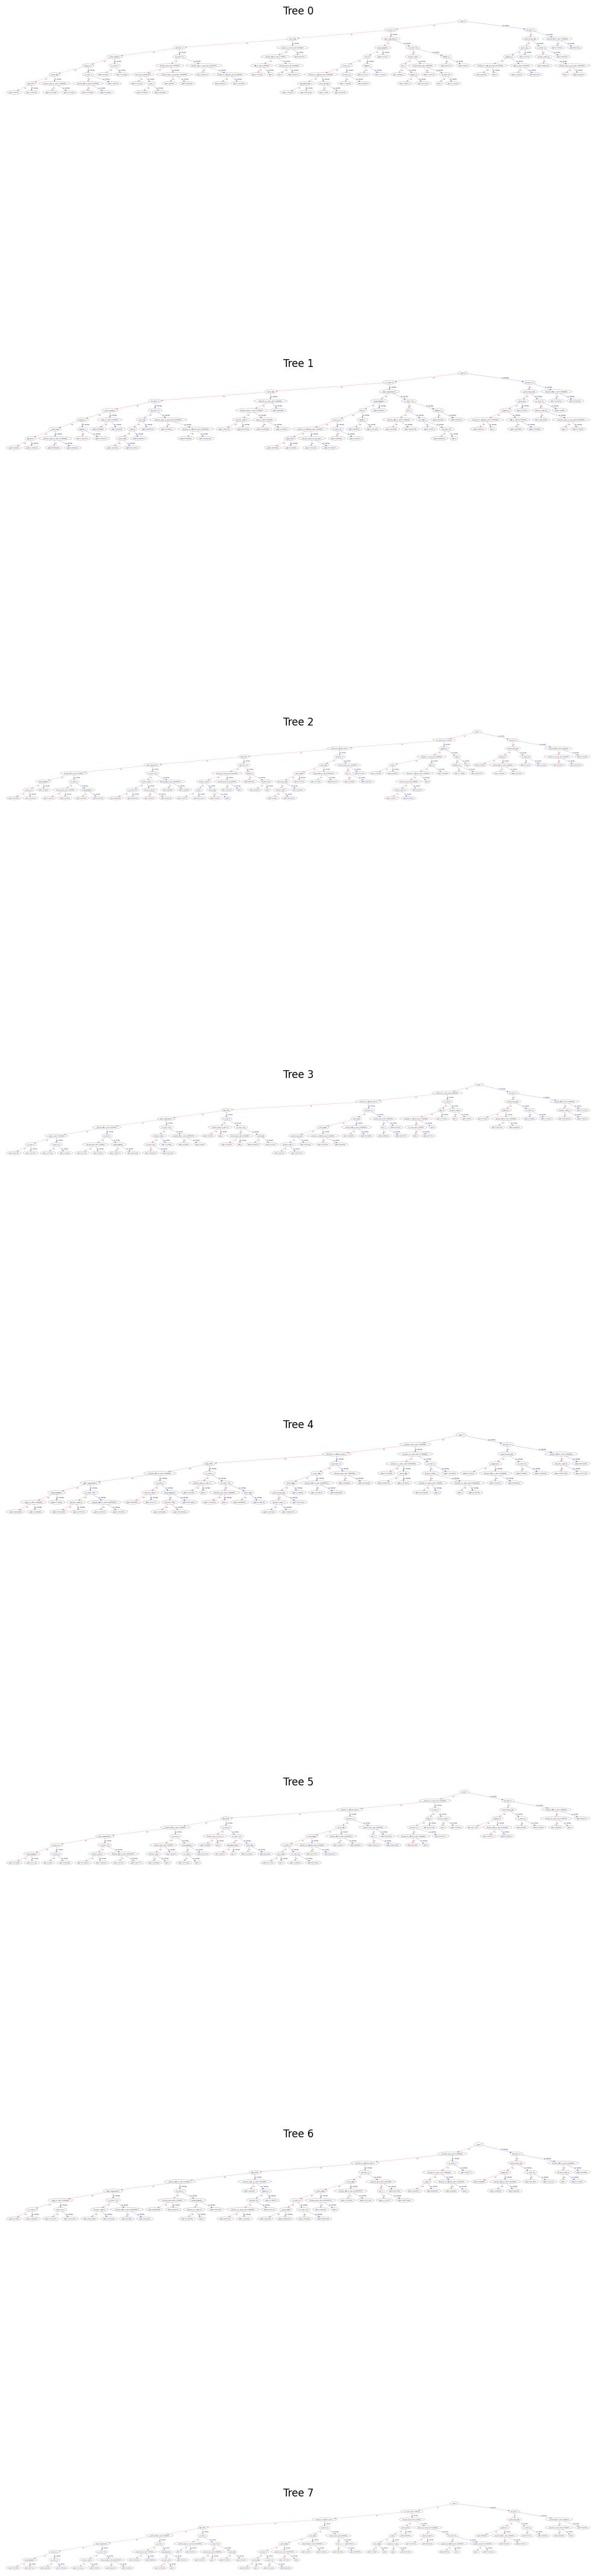

In [21]:
fig, axs = plt.subplots(8, 1, figsize=(10, 50))

for i in range(params_b['max_depth']):
    xgb.plot_tree(model, num_trees=i, ax=axs[i], figsize=(5, 10))
    axs[i].set_title(f'Tree {i}')

plt.tight_layout()
plt.show()

Confusion Matrix :


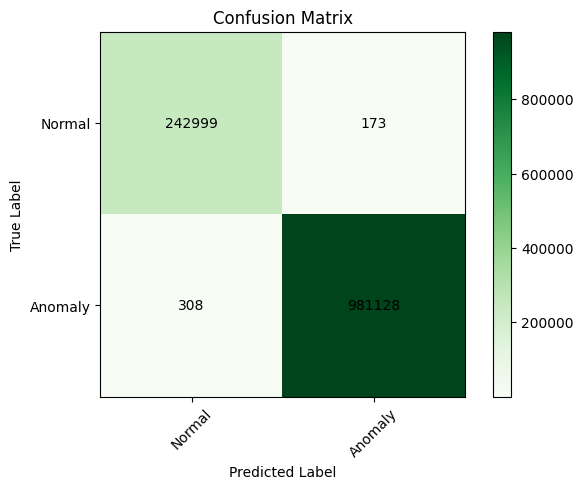

In [22]:
# Confusion Matrix - for Scoring

results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

ROC Curve (Receiver Operating Characteristic)

: 이진 분류 모델의 성능을 평가하는데 사용되는 그래픽 표현으로, 분류 모델의 민감도(TPR)와 거짓 양성 비율(FPR) 간의 trade off를 시각적으로 표현

In [23]:
fpr, tpr, threshold = roc_curve(true_labels, pred_labels)
fpr = np.asarray(fpr, dtype=np.float64)
tpr = np.asarray(tpr, dtype=np.float64)
print(fpr)
print(tpr)
print(threshold)

[0.00000000e+00 7.11430592e-04 1.00000000e+00]
[0.         0.99968617 1.        ]
[inf  1.  0.]


In [24]:
# AUC : Area Under the Curve
# ROC 곡선 아래 영역으로, 모델이 얼마나 잘 분류하는지를 나타냄

auc = roc_auc_score(true_labels, preds)
roc_auc = roc_auc_score(true_labels, pred_labels)
print(f"AUC : {auc}")
print(f"ROC_AUC : {auc}")
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

AUC : 0.999907496339263
ROC_AUC : 0.999907496339263
Accuracy: 0.9996072212495754


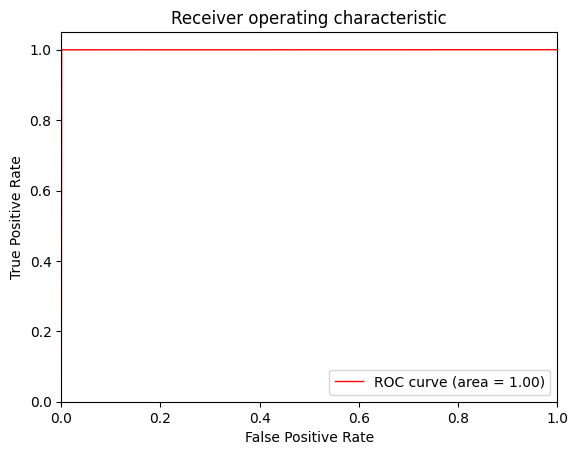

In [25]:
# ROC Curve : 직사각형에 가까울수록 모델이 잘 분류하고 있음을 의미

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

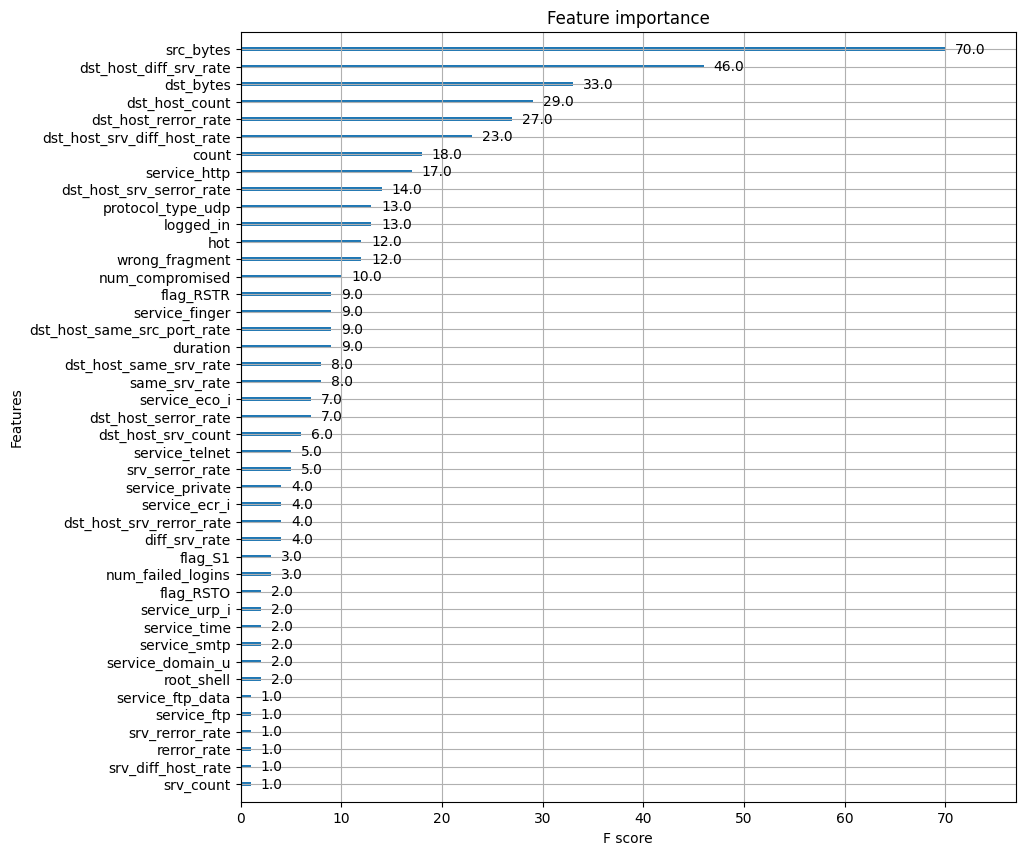

In [26]:
# Feature Importance에 대한 Insight
## 상대적으로 feature 중요도가 낮은 feature들을 제거하여 모델의 경량화가 가능

ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

#### * Skewed Data
abnormal data가 normal data보다 현저히 많은 데이터셋을 사용한 결과로, abnormal data를 제거하여 데이터셋의 이상치 비율을 조정하는 것이 필요

이상치가 너무 많아 훈련 데이터가 불균형 하다면, 정상적인 패턴 학습이 어렵고, 실제 환경에서는 이상치 비율이 상대적으로 더 적을 수 있개 때문에 이상치에 대한 일반화가 향상되는 오류가 발생할 수 있다. 이를 통해 데이터셋의 크기를 줄여 computational expense를 줄일 수 있고 데이터 불균형을 해소할 수 있다.

In [27]:
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal.'
    num_normal = np.sum(~is_anomaly)    # 비트 연산자로, 1과 0을 뒤집는 역할
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal.']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df

In [28]:
# df는 변경되지 않았다!
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [29]:
# abnormal data를 normal data의 10%로 줄임
df_skewd = reduce_anomalies(df)

In [30]:
pd.DataFrame(df_skewd['label'].value_counts())

,count
label,
normal.,972781
smurf.,6957
neptune.,2653
satan.,45
ipsweep.,25
portsweep.,24
nmap.,8
back.,7
teardrop.,3


Data Preprocessing for Skewed Data

In [31]:
categorical_data_skewd = pd.get_dummies(df_skewd[categorical_vars], drop_first=True)
categorical_data_skewd.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,1,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0,1,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,0,1,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,0,1,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [32]:
categorical_data_skewd.nunique()

land                 2
logged_in            2
is_host_login        2
is_guest_login       2
protocol_type_tcp    2
                    ..
flag_S1              2
flag_S2              2
flag_S3              2
flag_SF              2
flag_SH              2
Length: 76, dtype: int64

In [33]:
numerical_vars_skewd = list(set(df_skewd.columns.values.tolist()) - set(categorical_vars))
numerical_vars_skewd.remove('label')
numerical_data_skewd = df_skewd[numerical_vars_skewd].copy()

numerical_data_skewd.head()

,dst_host_diff_srv_rate,duration,count,num_access_files,srv_count,num_compromised,dst_host_srv_serror_rate,diff_srv_rate,num_shells,srv_diff_host_rate,num_outbound_cmds,su_attempted,dst_host_srv_rerror_rate,dst_host_count,srv_serror_rate,dst_bytes,wrong_fragment,src_bytes,root_shell,rerror_rate,same_srv_rate,urgent,dst_host_same_srv_rate,srv_rerror_rate,dst_host_serror_rate,num_file_creations,num_root,dst_host_srv_count,serror_rate,dst_host_same_src_port_rate,hot,dst_host_srv_diff_host_rate,dst_host_rerror_rate,num_failed_logins
0,0.0,0,1,0,1,0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,45076,0,215,0,0.0,1.0,0,0.0,0.0,0.0,0,0,0,0.0,0.00,0,0.0,0.0,0
1,0.0,0,2,0,2,0,0.0,0.0,0,0.0,0,0,0.0,1,0.0,4528,0,162,0,0.0,1.0,0,1.0,0.0,0.0,0,0,1,0.0,1.00,0,0.0,0.0,0
2,0.0,0,1,0,1,0,0.0,0.0,0,0.0,0,0,0.0,2,0.0,1228,0,236,0,0.0,1.0,0,1.0,0.0,0.0,0,0,2,0.0,0.50,0,0.0,0.0,0
3,0.0,0,2,0,2,0,0.0,0.0,0,0.0,0,0,0.0,3,0.0,2032,0,233,0,0.0,1.0,0,1.0,0.0,0.0,0,0,3,0.0,0.33,0,0.0,0.0,0
4,0.0,0,3,0,3,0,0.0,0.0,0,0.0,0,0,0.0,4,0.0,486,0,239,0,0.0,1.0,0,1.0,0.0,0.0,0,0,4,0.0,0.25,0,0.0,0.0,0


In [34]:
# Get X_skewd Data

# concat numeric and cate
x_data_skewd = pd.concat([numerical_data_skewd, categorical_data_skewd], axis=1)

print(categorical_data_skewd.shape)
print(numerical_data_skewd.shape)
print(x_data_skewd.shape)

(982508, 76)
(982508, 34)
(982508, 110)


In [35]:
# Get Y_skewd Data (label)

labels_skewd = df_skewd['label'].copy()
    # labels의 변경은 원본 데이터에 영향 없음
le_skewd = LabelEncoder()     # 정수 인코딩 객체 생성
le_skewd.fit(df_skewd['label'])
print(le_skewd.classes_)
integer_labels_skewd = le_skewd.transform(labels_skewd)

x_train_skewd, x_test_skewd, y_train_skewd, y_test_skewd = train_test_split(x_data_skewd,
                                                    integer_labels_skewd,
                                                    test_size=.25, 
                                                    random_state=42)

['back.' 'ipsweep.' 'neptune.' 'nmap.' 'normal.' 'pod.' 'portsweep.'
 'satan.' 'smurf.' 'teardrop.' 'warezclient.']


In [36]:
# check that the dimensions of our train and test sets are okay
print(x_train_skewd.shape)
print(y_train_skewd.shape)
print(x_test_skewd.shape)
print(y_test_skewd.shape)

(736881, 110)
(736881,)
(245627, 110)
(245627,)


In [37]:
# save the datasets for later use
preprocessed_data_skewd = {
    'x_train':x_train_skewd,
    'y_train':y_train_skewd,
    'x_test':x_test_skewd,
    'y_test':y_test_skewd,
    'le':le_skewd
}

# pickle the preprocessed_data
# pkckle : 파이썬 객체를 저장하고 로드하는 데 사용
path_skewd = r'C:\Users\원종복\Desktop\AINOW\03_NVIDIA AI ACADEMY\13_Abnormal_Detection\01_xgboost\data\preprocessed_data_skewd_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data_skewd, out)
out.close()

In [38]:
binary_y_train_skewd = convert_label_to_binary(le_skewd, y_train_skewd)
binary_y_test_skewd = convert_label_to_binary(le_skewd, y_test_skewd)

# check how many anomalies are in our labels
print('Number of anomalies in y_train_skewd: ', binary_y_train_skewd.sum())
print('Number of anomalies in y_test_skewd:  ', binary_y_test_skewd.sum())

Number of anomalies in y_train_skewd:  7261
Number of anomalies in y_test_skewd:   2466


In [39]:
%time

dtrain_skewd = xgb.DMatrix(x_train_skewd, label=binary_y_train_skewd)
dtest_skewd = xgb.DMatrix(x_test_skewd, label=binary_y_test_skewd)
evals_skewd = [(dtest_skewd, 'test'), (dtrain_skewd, 'train')]

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
model_skewd = xgb.train(params_b, dtrain_skewd, num_rounds, evals=evals_skewd)

c:\Users\원종복\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_gpus", "num_rounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-logloss:0.13570	train-logloss:0.13546
[1]	test-logloss:0.12046	train-logloss:0.12027
[2]	test-logloss:0.10753	train-logloss:0.10738
[3]	test-logloss:0.09628	train-logloss:0.09615
[4]	test-logloss:0.08637	train-logloss:0.08626
[5]	test-logloss:0.07760	train-logloss:0.07749
[6]	test-logloss:0.06979	train-logloss:0.06970
[7]	test-logloss:0.06282	train-logloss:0.06274
[8]	test-logloss:0.05659	train-logloss:0.05651
[9]	test-logloss:0.05101	train-logloss:0.05094


동일한 조건 하에서 이상치를 처리하지 않은 모델의 훈련 현황 비교 : model_skewd의 loss가 훨씬 더 적음을 알 수 있음

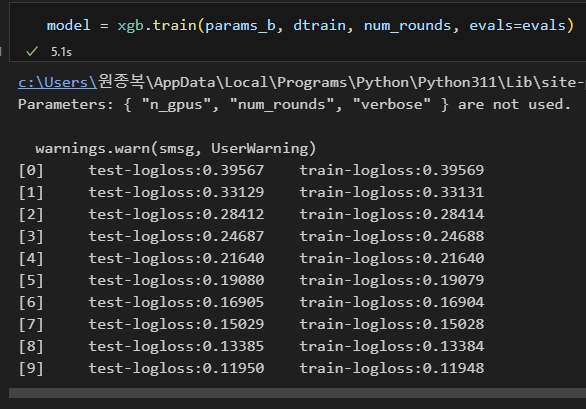

#### Test Skewd data

In [41]:
threshold_skewd = .5
true_labels_skewd = binary_y_test_skewd.astype(int)
true_labels_skewd.sum() # 2466

preds_skewd = model_skewd.predict(dtest_skewd)
print(preds_skewd)

[0.04678038 0.04678038 0.04678038 ... 0.04678038 0.04678038 0.04678038]


In [42]:
pred_labels_skewd = (preds_skewd > threshold_skewd).astype(int)
print(pred_labels_skewd.sum())

2452


Confusion Marix and check Accuracy

Confusion Matrix_skewd :


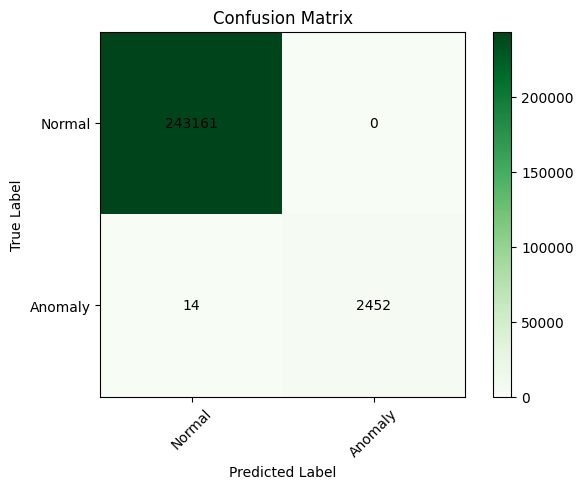

In [43]:
results_skewd = confusion_matrix(true_labels_skewd, pred_labels_skewd) 

print ('Confusion Matrix_skewd :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results_skewd, ['Normal','Anomaly'])

In [44]:
fpr_skewd, tpr_skewd, threshold_skewd = roc_curve(true_labels_skewd, pred_labels_skewd)
fpr_skewd = np.asarray(fpr_skewd, dtype=np.float64)
tpr_skewd = np.asarray(tpr_skewd, dtype=np.float64)
print(fpr_skewd)
print(tpr_skewd)
print(threshold_skewd)

[0. 0. 1.]
[0.         0.99432279 1.        ]
[inf  1.  0.]


In [45]:
# AUC : Area Under the Curve
# ROC 곡선 아래 영역으로, 모델이 얼마나 잘 분류하는지를 나타냄

auc_skewd = roc_auc_score(true_labels_skewd, preds_skewd)
roc_auc_skewd = roc_auc_score(true_labels_skewd, pred_labels_skewd)
print(f"AUC_skewd : {auc_skewd}")
print(f"ROC_AUC_skewd : {roc_auc_skewd}")
print ('Accuracy_skewd:', accuracy_score(true_labels_skewd, pred_labels_skewd))

AUC_skewd : 0.9993824493501151
ROC_AUC_skewd : 0.9971613949716139
Accuracy_skewd: 0.9999430030086269


이상치를 상당부분 제거하더라도 정확도 및 AUC 값이 거의 변화 없다는 점에서 추가적인 경량화도 가능할 것으로 보임

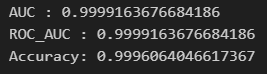

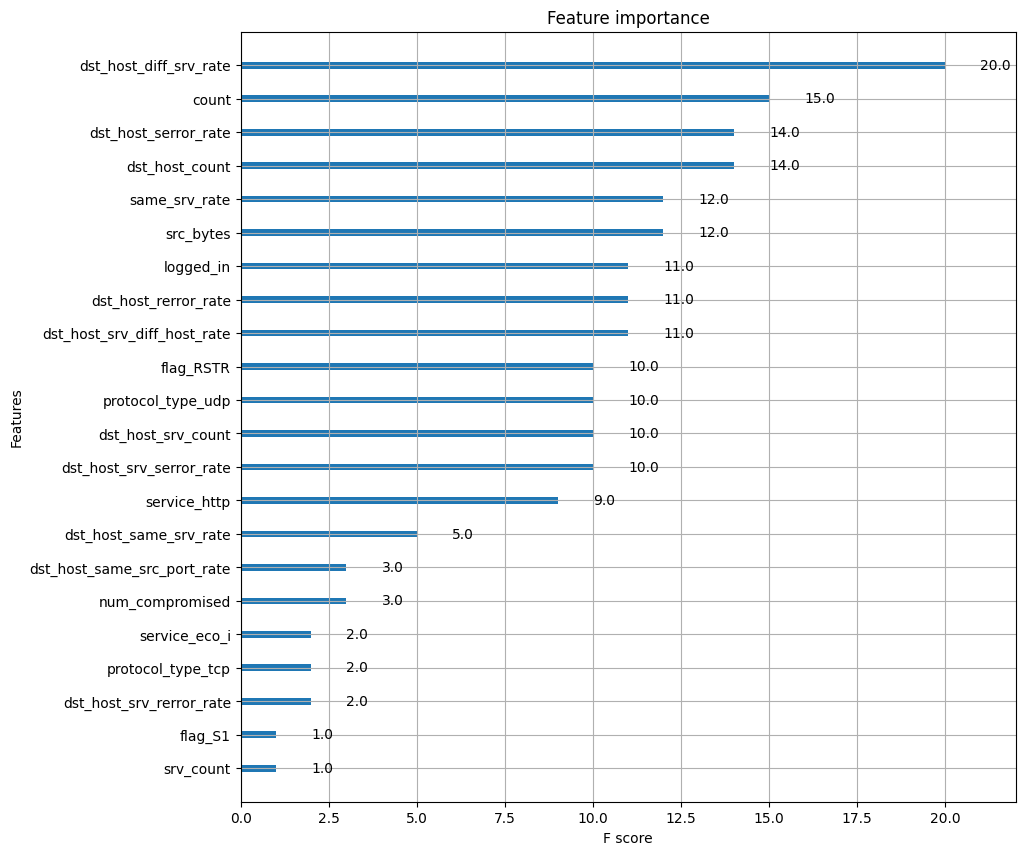

In [46]:
# Feature Importance에 대한 Insight
## 추가적으로 feature 중요도가 낮은 feature들을 제거하여 모델의 경량화가 가능

ax_skewd = xgb.plot_importance(model_skewd)
fig_skewd = ax_skewd.figure
fig_skewd.set_size_inches(10, 10)